In [1]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci

import sklearn.ensemble as se
import sklearn.model_selection as ms
import sklearn.metrics as sm

import seaborn as sns
import math
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap
shap.initjs()
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
#Import the preprocessed data
new_df = pd.read_excel('Preprocessed AQY data.xlsx')
new_df = new_df.iloc[:,1:]
new_df.describe()

,Reference,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Φ3DOM*(10-2),Φ1O2(10-2),Φ·OH(10-4)
count,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1063.000000,793.000000,499.000000
mean,21.072235,0.089541,0.336343,0.574116,0.542513,0.261099,0.196388,7.469506,8.650689,6.374037,6.209635,1.610804,0.822692,0.699812,3.429695,3.448188,0.801934
std,14.524000,0.285631,0.472636,0.494662,0.498377,0.439399,0.397415,0.927645,8.806242,3.857318,2.874673,0.292497,0.097619,0.182165,3.050921,2.521926,1.504777
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.430000,0.119526,1.685400,0.590000,0.240000,0.080000,0.020900,0.230000,0.013000
25%,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.260000,3.830000,4.600000,1.470000,0.760000,0.599000,1.400000,1.670000,0.141000
50%,16.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.655600,6.350000,5.757500,5.513800,1.576000,0.851000,0.709000,2.680000,2.700000,0.320000
75%,32.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,8.060000,10.000000,8.041727,6.900000,1.673110,0.892590,0.809139,4.700000,4.520000,0.709000
max,53.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.700000,172.200000,27.313580,30.000000,3.110000,0.990000,2.250000,28.814730,17.020000,18.300000


In [3]:
#Split the dataset by three PPRIs
#Φ3DOM*
df_triplet = new_df.iloc[:,:-2]
df_triplet = df_triplet.dropna()
df_triplet.index=range(len(df_triplet.index))

display(df_triplet.describe())

,Reference,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Φ3DOM*(10-2)
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,20.572907,0.092192,0.253998,0.653810,0.541863,0.326435,0.131703,7.669162,9.230855,6.456739,5.803471,1.634940,0.826856,0.701558,3.429695
std,15.373997,0.289433,0.435501,0.475979,0.498479,0.469129,0.338326,0.649509,9.233143,3.741504,1.942938,0.294230,0.100624,0.187679,3.050921
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.180000,0.430000,0.119526,1.685400,0.590000,0.240000,0.080000,0.020900
25%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.005000,4.500000,4.166048,4.580000,1.512505,0.763950,0.607000,1.400000
50%,16.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.900000,7.100000,5.978588,5.500000,1.580000,0.859578,0.703580,2.680000
75%,36.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,8.132400,10.505000,8.000000,6.653350,1.680000,0.896300,0.807749,4.700000
max,53.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.700000,172.200000,27.313580,16.895000,3.110000,0.990000,2.250000,28.814730


In [4]:
#Φ1O2
df_singlet = new_df.iloc[:,:-1]
df_singlet = df_singlet.dropna(subset=[df_singlet.columns[15]])
df_singlet.index=range(len(df_singlet.index))

display(df_singlet.describe())

,Reference,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Φ3DOM*(10-2),Φ1O2(10-2)
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,567.000000,793.000000
mean,26.704918,0.066835,0.461538,0.471627,0.421185,0.330391,0.248424,7.189740,8.323423,5.812383,6.460092,1.595646,0.807630,0.702014,2.783272,3.448188
std,15.214168,0.249893,0.498833,0.499509,0.494061,0.470651,0.432371,1.031813,7.733107,4.194599,3.488083,0.322586,0.110244,0.209514,2.824770,2.521926
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.590000,0.119526,1.685400,0.590000,0.240000,0.080000,0.020900,0.230000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,2.828084,4.460000,1.400000,0.720000,0.555550,1.032147,1.670000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.200000,5.112033,4.721150,5.427400,1.565843,0.829614,0.729600,1.880000,2.700000
75%,40.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,7.920000,9.500000,7.599900,7.268000,1.700000,0.889690,0.830000,3.430000,4.520000
max,53.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.700000,69.000000,27.313580,30.000000,3.110000,0.990000,2.250000,24.580000,17.020000


In [5]:
#Φ·OH
df_hydroxyl = pd.concat([new_df.iloc[:,:-2],new_df.iloc[:,-1]],axis=1)
df_hydroxyl = df_hydroxyl.dropna(subset=[df_hydroxyl.columns[15]])
df_hydroxyl.index=range(len(df_hydroxyl.index))

display(df_hydroxyl.describe())

,Reference,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Φ3DOM*(10-2),Φ·OH(10-4)
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,407.000000,499.000000
mean,28.757515,0.032064,0.390782,0.577154,0.468938,0.396794,0.134269,7.368570,9.282847,6.091684,5.850551,1.599293,0.820048,0.664792,2.694114,0.801934
std,15.820508,0.176347,0.488415,0.494507,0.499535,0.489723,0.341283,0.669975,8.674598,4.399877,2.880034,0.347214,0.118812,0.192779,2.244276,1.504777
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.950000,0.590000,1.105440,1.823077,0.590000,0.240000,0.080000,0.020900,0.013000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,3.265000,4.276000,1.420000,0.742009,0.510000,1.239901,0.141000
50%,36.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.200000,7.020000,4.798000,5.230000,1.560000,0.856278,0.707100,2.030000,0.320000
75%,43.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,8.000000,10.000000,7.504901,6.794813,1.707498,0.900000,0.809941,3.396098,0.709000
max,53.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.700000,69.000000,27.313580,30.000000,3.110000,0.990000,1.100000,20.000000,18.300000


## Split the dataset and screening the algorithm

In [6]:
#Split the dataset 
df_PPRIs = [df_triplet,df_singlet,df_hydroxyl]
trainx,trainy,testx,testy=[],[],[],[]
ppris = ["Φ3DOM*","Φ1O2","Φ·OH"]
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    x = df_PPRIs[i].iloc[:,1:14]
    #Natural logarithmic conversion of the target
    y = df_PPRIs[i].iloc[:,-1].apply(np.log)
    ran_seed = 42

    train_x, test_x, train_y, test_y = ms.train_test_split(x, y, test_size = 0.2, random_state = ran_seed, shuffle=True)
    display(train_x)
    display(train_y)
    trainx.append(train_x)
    trainy.append(train_y)
    testx.append(test_x)
    testy.append(test_y)

______________['Φ3DOM*']______________


,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX
72,0,0,1,1,0,0,8.12,21.85,7.807170,7.090000,1.527000,0.877000,0.669000
901,0,1,0,0,1,0,7.00,4.82,19.230050,2.610000,0.880250,0.751944,0.735211
44,0,0,1,1,0,0,7.02,6.35,7.622930,4.620000,1.467000,0.880000,0.496000
309,0,0,1,0,1,0,7.76,5.97,8.855071,4.961386,1.553160,0.882320,0.633900
787,0,0,1,0,1,0,6.50,4.00,4.680000,4.160000,1.380000,0.970000,0.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0,0,1,0,0,1,7.64,4.05,2.210880,10.510000,1.825090,0.688370,0.819447
466,0,0,1,1,0,0,8.00,5.60,6.500000,5.100000,1.550000,0.800000,0.814000
121,0,0,1,1,0,0,8.95,21.14,6.816880,7.910000,1.566000,0.895000,0.676000
1044,0,0,1,1,0,0,7.32,13.02,1.238100,5.769200,1.591700,0.715900,0.932300


72      1.226712
901     1.528228
44      0.530628
309     0.412110
787     0.548121
          ...   
330     0.254940
466     1.504077
121     1.621366
1044    0.787191
860     0.796188
Name: Φ3DOM*(10-2), Length: 850, dtype: float64

______________['Φ1O2']______________


,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX
323,1,0,0,1,0,0,7.3172,8.40,1.644286,11.12,1.793635,0.677971,0.838888
362,0,0,1,0,0,1,4.6446,1.70,1.393255,13.00,1.330000,0.714412,0.762979
79,0,0,1,0,1,0,6.5000,3.00,4.698120,7.55,1.470000,0.850000,0.540000
148,0,0,1,0,1,0,7.7700,14.30,10.662890,5.01,1.577400,0.904200,0.598310
694,0,0,1,1,0,0,7.9000,8.68,1.727250,7.28,2.150000,0.750000,0.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0,1,0,1,0,6.8100,3.91,6.517490,6.00,1.430000,0.900000,0.480000
106,0,0,1,0,0,1,7.5000,4.50,11.745300,4.40,1.400000,0.782838,0.760611
270,0,0,1,0,1,0,7.8000,3.24,1.941429,4.28,1.908212,0.736065,0.804072
435,0,1,0,1,0,0,3.0000,5.00,2.648450,13.27,1.540408,0.718909,0.711287


323    1.644805
362    1.131402
79     0.841567
148    0.165514
694    1.902108
         ...   
71     0.774727
106    0.788457
270    1.948763
435    2.283402
102    0.943906
Name: Φ1O2(10-2), Length: 634, dtype: float64

______________['Φ·OH']______________


,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX
56,0,0,1,0,1,0,8.50,3.000000,6.28719,6.900,1.470000,0.900000,0.500000
227,0,1,0,1,0,0,7.20,11.700000,2.01000,3.700,1.540000,0.690084,0.813749
280,0,0,1,0,1,0,6.50,4.000000,2.66000,6.090,1.280000,0.870000,0.360000
486,0,0,1,1,0,0,7.32,4.640000,2.53190,6.750,1.611100,0.686800,0.772400
220,0,1,0,0,1,0,7.00,10.000000,15.54525,2.700,1.210840,0.788044,0.740031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,1,1,0,0,8.20,23.100000,5.10000,9.700,1.561900,0.870880,0.710120
270,0,0,1,0,1,0,6.50,4.000000,4.80000,4.560,1.400000,0.960000,0.340000
348,0,1,0,0,0,1,7.00,7.462713,2.69100,5.704,1.908712,0.695679,0.811025
435,0,1,0,1,0,0,8.00,8.500000,13.33437,2.700,1.300000,0.970000,0.400000


56    -2.430418
227   -1.832581
280   -2.780621
486    0.928016
220   -2.207275
         ...   
106   -0.261365
270   -2.103734
348   -0.341083
435   -2.407946
102   -0.478036
Name: Φ·OH(10-4), Length: 399, dtype: float64

In [7]:
#Model performance with default hyperparameters
#Ensemble learning models 
estimators = [se.RandomForestRegressor(random_state=ran_seed),
             se.GradientBoostingRegressor(random_state=ran_seed),
             xgb.XGBRegressor(random_state=ran_seed),
             lgb.LGBMRegressor(random_state=ran_seed),
             cb.CatBoostRegressor(random_state=ran_seed, verbose=False)]
name = ['RF','GBDT','XGB','LGB','CB']
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    model_results=[]
    index_name =[]
    for n in range(len(estimators)):
        model = estimators[n]
        model.fit(trainx[i], trainy[i])

        scores = ms.cross_validate(model, trainx[i], trainy[i], cv=5, scoring=['r2','neg_root_mean_squared_error'])
        pred_train_y = model.predict(trainx[i])
        train_rmse = math.sqrt(sm.mean_squared_error(trainy[i], pred_train_y))

        index_name.append('{} default'.format(name[n]))
        model_results.append(np.array([model.score(trainx[i], trainy[i]),scores.get('test_r2').mean(),
                                        train_rmse, -scores.get('test_neg_root_mean_squared_error').mean()]))
    total_model_results = pd.DataFrame(model_results, index=index_name, columns=['train_R2','cv_R2','train_rmse','cv_rmse'])
    display(total_model_results)

______________['Φ3DOM*']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.949219,0.610462,0.205625,0.566753
GBDT default,0.831443,0.593484,0.374625,0.579968
XGB default,0.998888,0.592142,0.030433,0.581045
LGB default,0.937131,0.606725,0.228792,0.570891
CB default,0.967254,0.705386,0.165121,0.494294


______________['Φ1O2']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.953059,0.635654,0.157033,0.435681
GBDT default,0.847507,0.621916,0.283035,0.443342
XGB default,0.999696,0.667937,0.012641,0.415820
LGB default,0.961581,0.691691,0.142066,0.400543
CB default,0.977400,0.724370,0.108961,0.379472


______________['Φ·OH']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.953505,0.628141,0.260415,0.726566
GBDT default,0.898235,0.609060,0.385267,0.742231
XGB default,0.999954,0.606264,0.008175,0.741072
LGB default,0.947518,0.606735,0.276675,0.739531
CB default,0.986201,0.681254,0.141871,0.667678


## CatBoost

In [8]:
#After tunning the hyperparameters by BayesSearch, the optimal CB model for each PPRIs is developed 
#The developed model will be exported as a pickle named "Triplet.pickle" , "Singlet.pickle" or "Hydroxyl.pickle" for the further application
best_cbr = [cb.CatBoostRegressor(random_state=42, verbose=False,iterations=360, depth=6, learning_rate=0.12, subsample=0.8, rsm=0.2, 
                                random_strength=12),
           cb.CatBoostRegressor(random_state=42, verbose=False,iterations=350, depth=7,learning_rate=0.11, rsm=0.2,subsample=0.9, 
                                random_strength=87),
           cb.CatBoostRegressor(random_state=42, verbose=False,iterations=290, depth=9,learning_rate=0.09, rsm=0.2,subsample=0.8,
                                random_strength=94)]
df_PPRIs = [df_triplet,df_singlet,df_hydroxyl]
ppris = ["Φ3DOM*","Φ1O2","Φ·OH"]
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    best_cbr[i].fit(trainx[i], trainy[i])
    pred_train_y = best_cbr[i].predict(trainx[i])
    pred_test_y = best_cbr[i].predict(testx[i])

    scores = ms.cross_validate(best_cbr[i], trainx[i], trainy[i], cv=5, scoring=['r2','neg_root_mean_squared_error'])
    test_r = best_cbr[i].score(testx[i], testy[i])
    train_r = best_cbr[i].score(trainx[i], trainy[i])

    train_rmse = math.sqrt(sm.mean_squared_error(trainy[i], pred_train_y))
    test_rmse = math.sqrt(sm.mean_squared_error(testy[i], pred_test_y))
    cv_R2 = scores.get('test_r2').mean()
    cv_RMSE = -scores.get('test_neg_root_mean_squared_error').mean()

    print('CatBoost for {}:'.format(ppris[i]))
    print(best_cbr[i].get_all_params())
    print('\n R2  Train: {:.4f}'.format(train_r), ' Test: {:.4f}'.format(test_r), 
          ' CV: {:.4f} (+/- {:.4f})'.format(cv_R2,scores.get('test_r2').std()))
    print('RMSE Train: {:.4f}'.format(train_rmse),' Test: {:.4f}'.format(test_rmse), 
          ' CV: {:.4f} (+/- {:.4f})\n'.format(cv_RMSE, scores.get('test_neg_root_mean_squared_error').std())) 

______________['Φ3DOM*']______________
CatBoost for Φ3DOM*:
{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 360, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 12, 'rsm': 0.20000000298023224, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.1199999973177

______________['Φ3DOM*']______________


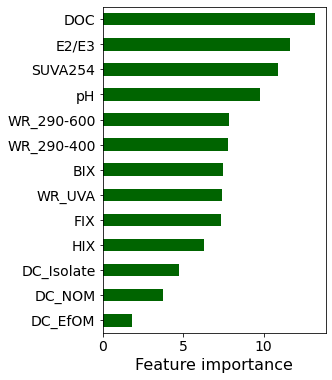

______________['Φ1O2']______________


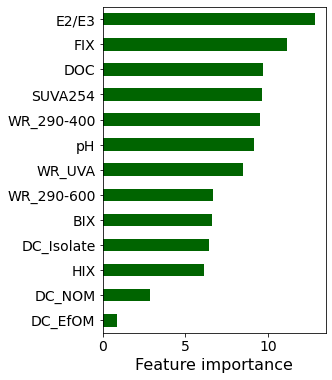

______________['Φ·OH']______________


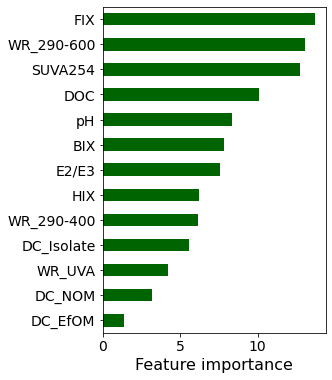

In [9]:
#Feature importance
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    fi = best_cbr[i].feature_importances_
    s = pd.Series(fi, trainx[i].columns)
    s.sort_values().plot.barh(color='darkgreen',figsize=[4,6])
    plt.xlabel("Feature importance", size=16)
    plt.tick_params(labelsize=14)
    plt.show()

______________['Φ3DOM*']______________


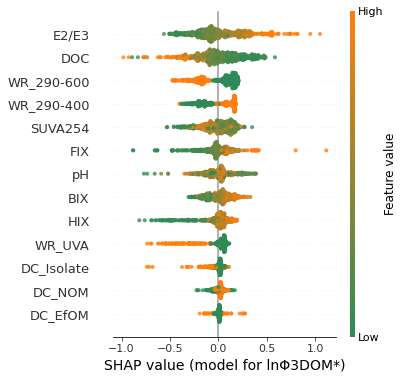

______________['Φ1O2']______________


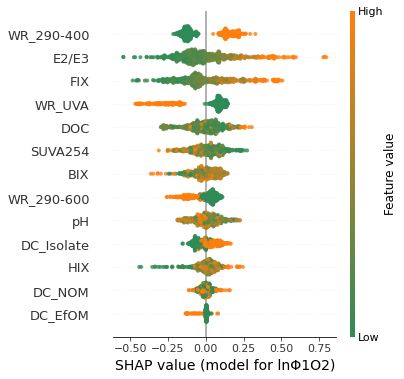

______________['Φ·OH']______________


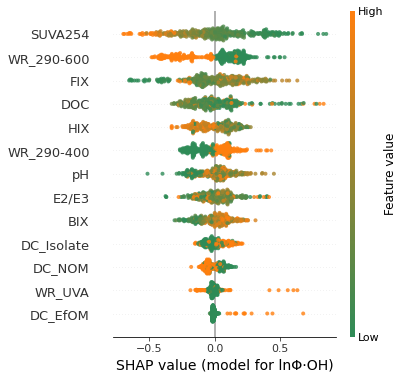

In [10]:
#SHAP summary plot
colors = ["seagreen","tab:orange"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    explainer = shap.TreeExplainer(best_cbr[i])
    shap_values = explainer(trainx[i]) 
    shap.summary_plot(shap_values, trainx[i],show = False, feature_names=trainx[i].columns, cmap=cmap1,alpha=0.8, plot_size=(5,6))
    plt.xlabel('SHAP value (model for ln{})'.format(ppris[i]),size=14)
    plt.show()

______________['Φ3DOM*']______________


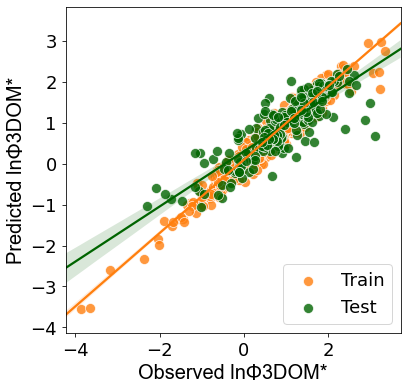

______________['Φ1O2']______________


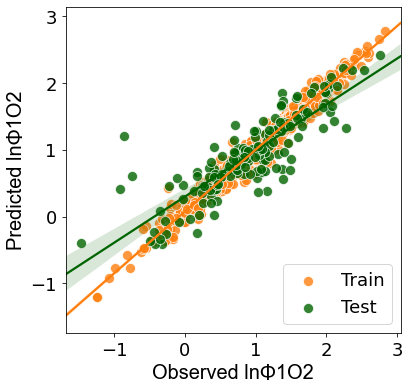

______________['Φ·OH']______________


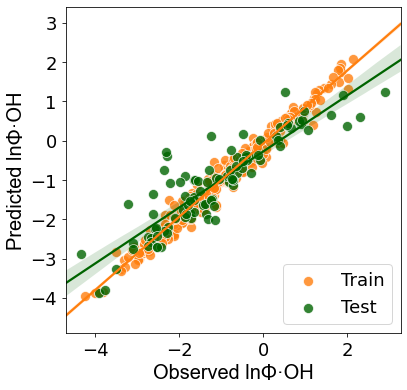

In [11]:
for i in range(3):
    print("______________{}______________".format([ppris[i]]))
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=trainy[i], y=best_cbr[i].predict(trainx[i]), s=100, color='tab:orange',  edgecolor='1',alpha=0.8)
    sns.scatterplot(x=testy[i], y=best_cbr[i].predict(testx[i]), s=100, color='darkgreen',  edgecolor='1',alpha=0.8)
    plt.legend(["Train", "Test"], loc='lower right', frameon=True, fontsize=18)
    sns.regplot(x=testy[i], y=best_cbr[i].predict(testx[i]), color='darkgreen',  scatter=False, truncate=False)
    sns.regplot(x=trainy[i], y=best_cbr[i].predict(trainx[i]), color='tab:orange', scatter=False, truncate=False)
    plt.tick_params(direction='out',length=4,width=0.8, labelsize=18, pad=5)

    plt.xlabel("Observed ln{}".format(ppris[i]), fontsize =20, fontname = 'Arial')
    plt.ylabel("Predicted ln{}".format(ppris[i]), fontsize =20, fontname = 'Arial')
    plt.show()

## Chain model 

In [12]:
for i in range(2):
    #Split the dataset
    x1 = df_PPRIs[i+1].iloc[:,1:14]
    y1= df_PPRIs[i+1].iloc[:,-1].apply(np.log)
    ran_seed = 42

    #Apply the predicted lnΦ3DOM* as a new feature of Φ1O2 and Φ·OH dataset
    pred_triplet1 = best_cbr[0].predict(x1)
    x1['Predicted ln(Φ3DOM*)'] = pred_triplet1

    train_x, test_x, train_y, test_y = ms.train_test_split(x1, y1, test_size = 0.2, random_state = ran_seed)
    print("______________{}______________".format([ppris[i+1]]))
    display(train_x)
    trainx.append(train_x)
    testx.append(test_x)

______________['Φ1O2']______________


,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Predicted ln(Φ3DOM*)
323,1,0,0,1,0,0,7.3172,8.40,1.644286,11.12,1.793635,0.677971,0.838888,1.978039
362,0,0,1,0,0,1,4.6446,1.70,1.393255,13.00,1.330000,0.714412,0.762979,-0.646138
79,0,0,1,0,1,0,6.5000,3.00,4.698120,7.55,1.470000,0.850000,0.540000,1.072479
148,0,0,1,0,1,0,7.7700,14.30,10.662890,5.01,1.577400,0.904200,0.598310,-0.740729
694,0,0,1,1,0,0,7.9000,8.68,1.727250,7.28,2.150000,0.750000,0.820000,1.082698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0,1,0,1,0,6.8100,3.91,6.517490,6.00,1.430000,0.900000,0.480000,0.836997
106,0,0,1,0,0,1,7.5000,4.50,11.745300,4.40,1.400000,0.782838,0.760611,0.658666
270,0,0,1,0,1,0,7.8000,3.24,1.941429,4.28,1.908212,0.736065,0.804072,1.468250
435,0,1,0,1,0,0,3.0000,5.00,2.648450,13.27,1.540408,0.718909,0.711287,1.590755


______________['Φ·OH']______________


,DC_EfOM,DC_Isolate,DC_NOM,WR_290-400,WR_290-600,WR_UVA,pH,DOC,SUVA254,E2/E3,FIX,HIX,BIX,Predicted ln(Φ3DOM*)
56,0,0,1,0,1,0,8.50,3.000000,6.28719,6.900,1.470000,0.900000,0.500000,1.060714
227,0,1,0,1,0,0,7.20,11.700000,2.01000,3.700,1.540000,0.690084,0.813749,-0.202227
280,0,0,1,0,1,0,6.50,4.000000,2.66000,6.090,1.280000,0.870000,0.360000,-1.022294
486,0,0,1,1,0,0,7.32,4.640000,2.53190,6.750,1.611100,0.686800,0.772400,0.352174
220,0,1,0,0,1,0,7.00,10.000000,15.54525,2.700,1.210840,0.788044,0.740031,0.562316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,1,1,0,0,8.20,23.100000,5.10000,9.700,1.561900,0.870880,0.710120,1.714875
270,0,0,1,0,1,0,6.50,4.000000,4.80000,4.560,1.400000,0.960000,0.340000,0.432683
348,0,1,0,0,0,1,7.00,7.462713,2.69100,5.704,1.908712,0.695679,0.811025,1.271827
435,0,1,0,1,0,0,8.00,8.500000,13.33437,2.700,1.300000,0.970000,0.400000,-0.232122


In [13]:
#Model performance with default hyperparameters
#Ensemble learning models 
estimators = [se.RandomForestRegressor(random_state=ran_seed),
             se.GradientBoostingRegressor(random_state=ran_seed),
             xgb.XGBRegressor(random_state=ran_seed),
             lgb.LGBMRegressor(random_state=ran_seed),
             cb.CatBoostRegressor(random_state=ran_seed, verbose=False)]
name = ['RF','GBDT','XGB','LGB','CB']
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    model_results=[]
    index_name =[]
    for n in range(len(estimators)):
        model = estimators[n]
        model.fit(trainx[i+3], trainy[i+1])

        scores = ms.cross_validate(model, trainx[i+3], trainy[i+1], cv=5, scoring=['r2','neg_root_mean_squared_error'])
        pred_train_y = model.predict(trainx[i+3])
        train_rmse = math.sqrt(sm.mean_squared_error(trainy[i+1], pred_train_y))

        index_name.append('{} default'.format(name[n]))
        model_results.append(np.array([model.score(trainx[i+3], trainy[i+1]),scores.get('test_r2').mean(),
                                        train_rmse, -scores.get('test_neg_root_mean_squared_error').mean()]))
    total_model_results = pd.DataFrame(model_results, index=index_name, columns=['train_R2','cv_R2','train_rmse','cv_rmse'])
    display(total_model_results)

______________['Φ1O2']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.960300,0.683454,0.144414,0.407221
GBDT default,0.867591,0.651367,0.263738,0.426752
XGB default,0.999828,0.689449,0.009502,0.403469
LGB default,0.971117,0.708031,0.123179,0.390141
CB default,0.982662,0.737377,0.095435,0.370632


______________['Φ·OH']______________


,train_R2,cv_R2,train_rmse,cv_rmse
RF default,0.956536,0.648549,0.251782,0.705667
GBDT default,0.904344,0.648861,0.373524,0.703580
XGB default,0.999971,0.649095,0.006474,0.698687
LGB default,0.953931,0.668557,0.259220,0.677147
CB default,0.988874,0.717819,0.127389,0.627991


## Chain CatBoost

In [14]:
#The developed chain model will be exported as a pickle named "Tri-singlet.pickle" or "Tri-hydroxyl.pickle" for the further application
ppris = ["Φ3DOM*","Φ1O2","Φ·OH"]
chain_cbr = [cb.CatBoostRegressor(random_state=ran_seed, verbose=False, depth=6, iterations=370, learning_rate=0.12, rsm=0.2, subsample=0.9,
                                random_strength=18),
           cb.CatBoostRegressor(random_state=ran_seed, verbose=False, depth=6, iterations=260, learning_rate=0.1, rsm=0.3, subsample=0.8,
                                random_strength=22)]
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    chain_cbr[i].fit(trainx[i+3], trainy[i+1])
    pred_train_y = chain_cbr[i].predict(trainx[i+3])
    pred_test_y = chain_cbr[i].predict(testx[i+3])

    scores = ms.cross_validate(chain_cbr[i], trainx[i+3], trainy[i+1], cv=5, scoring=['r2','neg_root_mean_squared_error'])
    test_r = chain_cbr[i].score(testx[i+3], testy[i+1])
    train_r = chain_cbr[i].score(trainx[i+3], trainy[i+1])
    train_rmse = math.sqrt(sm.mean_squared_error(trainy[i+1], pred_train_y))
    test_rmse = math.sqrt(sm.mean_squared_error(testy[i+1], pred_test_y))
    cv_R2 = scores.get('test_r2').mean()
    cv_RMSE = -scores.get('test_neg_root_mean_squared_error').mean()

    print('Chain CatBoost for {}:'.format(ppris[i+1]))
    print(best_cbr[i].get_all_params())
    print('\n R2  Train: {:.4f}'.format(train_r), ' Test: {:.4f}'.format(test_r), 
          ' CV: {:.4f} (+/- {:.4f})'.format(cv_R2,scores.get('test_r2').std()))
    print('RMSE Train: {:.4f}'.format(train_rmse),' Test: {:.4f}'.format(test_rmse), 
          ' CV: {:.4f} (+/- {:.4f})\n'.format(cv_RMSE, scores.get('test_neg_root_mean_squared_error').std())) 

______________['Φ1O2']______________
Chain CatBoost for Φ1O2:
{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 360, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 12, 'rsm': 0.20000000298023224, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.11999999731

______________['Φ1O2']______________


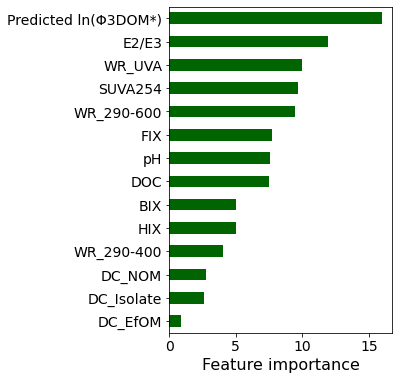

______________['Φ·OH']______________


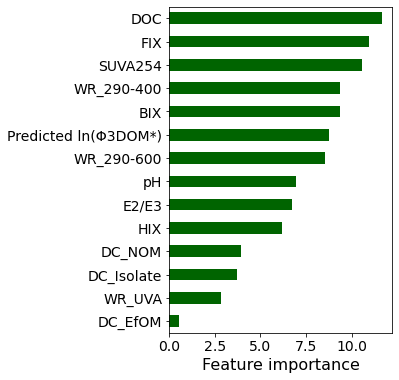

In [15]:
#Feature importance
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    fi = chain_cbr[i].feature_importances_
    s = pd.Series(fi, trainx[i+3].columns)

    s.sort_values().plot.barh(color='darkgreen',figsize=[4,6])
    plt.xlabel("Feature importance", size=16)
    plt.tick_params(labelsize=14)
    plt.show()

______________['Φ1O2']______________


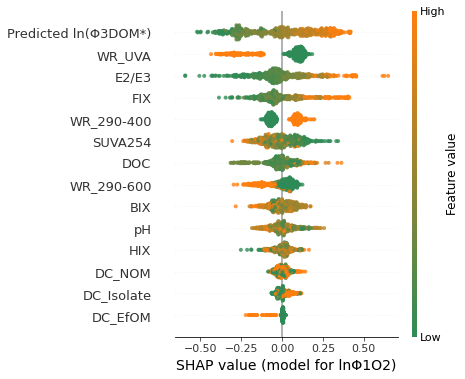

______________['Φ·OH']______________


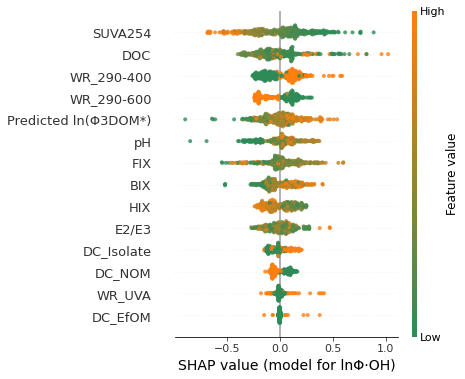

In [16]:
#SHAP summary plot
colors = ["seagreen","tab:orange"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    explainer = shap.TreeExplainer(chain_cbr[i])
    shap_values = explainer(trainx[i+3]) 
    shap.summary_plot(shap_values, trainx[i+3],show = False, feature_names=trainx[i+3].columns, cmap=cmap1,alpha=0.8, plot_size=(5,6))
    plt.xlabel('SHAP value (model for ln{})'.format(ppris[i+1]),size=14)
    plt.show()

______________['Φ1O2']______________


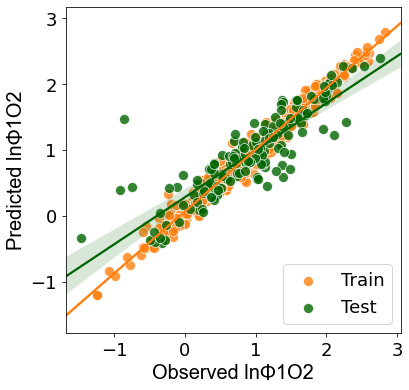

______________['Φ·OH']______________


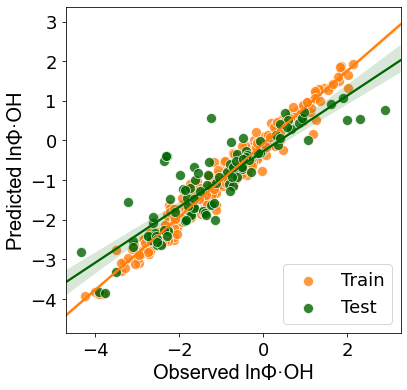

In [17]:
for i in range(2):
    print("______________{}______________".format([ppris[i+1]]))
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=trainy[i+1], y=chain_cbr[i].predict(trainx[i+3]), s=100, color='tab:orange',  edgecolor='1',alpha=0.8)
    sns.scatterplot(x=testy[i+1], y=chain_cbr[i].predict(testx[i+3]), s=100, color='darkgreen',  edgecolor='1',alpha=0.8)
    plt.legend(["Train", "Test"], loc='lower right', frameon=True, fontsize=18)
    sns.regplot(x=testy[i+1], y=chain_cbr[i].predict(testx[i+3]), color='darkgreen',  scatter=False, truncate=False)
    sns.regplot(x=trainy[i+1], y=chain_cbr[i].predict(trainx[i+3]), color='tab:orange', scatter=False, truncate=False)
    plt.tick_params(direction='out',length=4,width=0.8, labelsize=18, pad=5)

    plt.xlabel("Observed ln{}".format(ppris[i+1]), fontsize =20, fontname = 'Arial')
    plt.ylabel("Predicted ln{}".format(ppris[i+1]), fontsize =20, fontname = 'Arial')
    plt.show()